In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from tqdm import tqdm
import torch.optim as optim

# Definindo o caminho dos dados
IMAGE_PATH = "/content/drive/MyDrive/Colab Notebooks/dados/X"
MASK_PATH = "/content/drive/MyDrive/Colab Notebooks/dados/Y"

# Parâmetros de configuração
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
EPOCHS = 15
MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/segmentation/models/unet.pth"

# Verificando se GPU está disponível
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
class BovineDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
        self.mask_paths = [os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convertendo a máscara para escala de cinza

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Definindo as transformações (pode ser adaptado conforme necessário)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensionar as imagens
    transforms.ToTensor()  # Converter para tensor
])

# Criando o dataset
dataset = BovineDataset(image_dir=IMAGE_PATH, mask_dir=MASK_PATH, transform=transform)


In [ ]:
# Dividindo o dataset em treino e validação
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Criando dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
class ConvDupla(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_up = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_up(x)

# Downsample para reduzir a dimensão espacial da imagem
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvDupla(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

# Upsample para aumentar a dimensão espacial da imagem
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = ConvDupla(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

# Definição da UNet
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = ConvDupla(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out


In [ ]:
# Inicializando o modelo, o otimizador e a função de perda
model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Loop de treinamento
for epoch in range(EPOCHS):
    model.train()
    train_running_loss = 0
    for idx, (img, mask) in enumerate(tqdm(train_dataloader)):
        img = img.float().to(device)
        mask = mask.float().to(device)

        y_pred = model(img)
        optimizer.zero_grad()

        loss = criterion(y_pred, mask)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)

    # Validação
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, (img, mask) in enumerate(val_dataloader):
            img = img.float().to(device)
            mask = mask.float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)

            val_running_loss += loss.item()

        val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print("-"*30)

# Salvando o modelo
torch.save(model.state_dict(), MODEL_SAVE_PATH)


100%|██████████| 22/22 [04:58<00:00, 13.57s/it]


------------------------------
Train Loss EPOCH 1: 0.6925
Valid Loss EPOCH 1: 0.6911
------------------------------


100%|██████████| 22/22 [00:27<00:00,  1.26s/it]


------------------------------
Train Loss EPOCH 2: 0.6821
Valid Loss EPOCH 2: 0.6559
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.29s/it]


------------------------------
Train Loss EPOCH 3: 0.5725
Valid Loss EPOCH 3: 0.4067
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.31s/it]


------------------------------
Train Loss EPOCH 4: 0.3526
Valid Loss EPOCH 4: 0.3251
------------------------------


100%|██████████| 22/22 [00:29<00:00,  1.32s/it]


------------------------------
Train Loss EPOCH 5: 0.3008
Valid Loss EPOCH 5: 0.3089
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.31s/it]


------------------------------
Train Loss EPOCH 6: 0.2897
Valid Loss EPOCH 6: 0.2901
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.31s/it]


------------------------------
Train Loss EPOCH 7: 0.2877
Valid Loss EPOCH 7: 0.2971
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.31s/it]


------------------------------
Train Loss EPOCH 8: 0.2847
Valid Loss EPOCH 8: 0.2914
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.31s/it]


------------------------------
Train Loss EPOCH 9: 0.2855
Valid Loss EPOCH 9: 0.2903
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.31s/it]


------------------------------
Train Loss EPOCH 10: 0.2871
Valid Loss EPOCH 10: 0.2886
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.31s/it]


------------------------------
Train Loss EPOCH 11: 0.2900
Valid Loss EPOCH 11: 0.2899
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.31s/it]


------------------------------
Train Loss EPOCH 12: 0.2854
Valid Loss EPOCH 12: 0.2981
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.31s/it]


------------------------------
Train Loss EPOCH 13: 0.2834
Valid Loss EPOCH 13: 0.3013
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.32s/it]


------------------------------
Train Loss EPOCH 14: 0.2838
Valid Loss EPOCH 14: 0.2853
------------------------------


100%|██████████| 22/22 [00:28<00:00,  1.31s/it]


------------------------------
Train Loss EPOCH 15: 0.2817
Valid Loss EPOCH 15: 0.2853
------------------------------


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Colocando o modelo em modo de avaliação
model.eval()

# Obtendo um lote do dataloader de validação
val_batch = next(iter(val_dataloader))
images, true_masks = val_batch
images = images.to(device)

# Fazendo predições
with torch.no_grad():
    predictions = model(images)
    predictions = torch.sigmoid(predictions)  # Aplicando a função sigmóide para obter a probabilidade
    predictions = predictions.cpu().numpy()  # Movendo para a CPU e convertendo para numpy

# Transformando as predições em binário (0 ou 1) com um limiar de 0.5
pred_masks = (predictions > 0.5).astype(np.uint8)


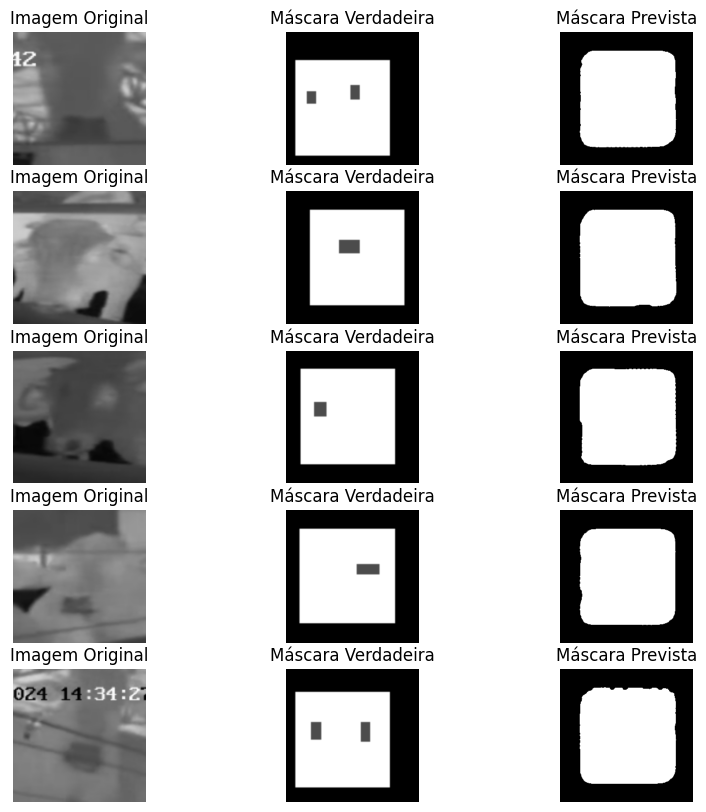

In [ ]:
def visualize_predictions(images, true_masks, pred_masks, num_images=4):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # Imagem original
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        plt.title("Imagem Original")
        plt.axis('off')

        # Máscara verdadeira
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(true_masks[i].cpu().numpy().squeeze(), cmap='gray')
        plt.title("Máscara Verdadeira")
        plt.axis('off')

        # Máscara prevista
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')
        plt.title("Máscara Prevista")
        plt.axis('off')

    plt.show()

# Visualizar as predições
visualize_predictions(images, true_masks, pred_masks, num_images=5)


## Adicionando o treinamento para comparação entre CPU x GPU e gráficos de comparação

In [ ]:
import time
import gc
from tensorflow.keras.backend import clear_session
import matplotlib.pyplot as plt

In [ ]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    # Predições binárias com limiar de 0.5
    y_pred = tf.cast(y_pred > 0.5, dtype='float32')

    # Intersection
    # Interseção entre as máscaras verdadeiras e previstas
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])

    # União 
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection

    # Computar o IoU (Intersection over Union)
    iou = (intersection + smooth) / (union + smooth)

    # Retornar a média do IoU sobre o lote
    return tf.reduce_mean(iou)


In [ ]:
def train_model_on_device(device, X_train, y_train, X_val, y_val):
    with tf.device(device):
        # Define o modelo dentro do contexto do dispositivo
        model = unet_vgg16_no_over((128, 128, 3))
        model.compile(optimizer=Adam(learning_rate=1e-3),
                      loss='binary_crossentropy',
                      metrics=['accuracy', iou_metric])  
        start_time = time.time()
        history = model.fit(
            X_train,
            y_train,
            epochs=35,
            validation_data=(X_val, y_val),
            batch_size=32,
            callbacks=[early_stopping],
            verbose=0  
        )
        end_time = time.time()
    training_time = end_time - start_time
    return training_time, history, model


In [ ]:
# Further split X_train and y_train into training and validation sets
# Define o tamanho do conjunto de validação 
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

print("Training data shape:", X_train_sub.shape)
print("Validation data shape:", X_val.shape)


In [ ]:
# Treinar o modelo na GPU
gpu_training_time, gpu_history, gpu_model = train_model_on_device(
    '/GPU:0', X_train_sub, y_train_sub, X_val, y_val)
print(f"Tempo de treinamento na GPU: {gpu_training_time:.2f} segundos")


In [ ]:
# Limpar sessão do TensorFlow para treinar na CPU
clear_session()
gc.collect()

In [ ]:
# Treinar o modelo na CPU
cpu_training_time, cpu_history, cpu_model = train_model_on_device(
    '/CPU:0', X_train_sub, y_train_sub, X_val, y_val)
print(f"Tempo de treinamento na CPU: {cpu_training_time:.2f} segundos")


In [ ]:
# Plotar o tempo de treinamento na CPU e GPU
labels = ['CPU', 'GPU']
times = [cpu_training_time, gpu_training_time]

plt.bar(labels, times, color=['blue', 'green'])
plt.ylabel('Tempo de Treinamento (s)')
plt.title('Comparação de Tempo de Treinamento entre CPU e GPU')
plt.show()
